## Import Neccessary Packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  # Returns split words, while tf vectorizes after splitting.

!pip install pyspellchecker
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

!pip install tensorflow-hub
!pip install tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0-rc1
Eager mode:  True
Hub version:  0.7.0
GPU is available


## Cleaning Functions:

In [0]:
def clean_tweet(uncleaned_tweet):
    # Order of operations:
    # 1. Remove symbols/emojis.
    # 2. Tokenize for subsequent processes.
    # 3. Remove http links.
    # 4. Replace contractions with root words.
    # 5. Remove @whatever.
    # 6. Separate and Remove '_', '#', '/', ''' in that order.
    # 7. Join and return.

    # Identify junk to be removed.
    symbols = ['*', '+', '...', '?', '`', '``', '[', ']', '(', ')', '-', '~', '|']
    
    emotes = ['\x89Û_', '\x89Ûªt', '\x89', '\x89ÛÏ', '\x89Ûªm', '\x89ÛÓ',
              '\x89Ûª', '\x89Û÷', '\x89ÛªS', 'RAZEDåÊ', '\x89ÛÒ', 'Ûªs']    
    

    def remove_symbols(uncleaned_tweet):
        for s in symbols:
            uncleaned_tweet = uncleaned_tweet.replace(s, ' ')
        uncleaned_tweet = uncleaned_tweet.replace('&', ' and ')
        return uncleaned_tweet


    uncleaned_tweet = remove_symbols(uncleaned_tweet)
    
    
    def remove_emote(uncleaned_tweet):
        for emote in emotes:
            uncleaned_tweet = uncleaned_tweet.replace(emote, '')
        return uncleaned_tweet


    uncleaned_tweet = remove_emote(uncleaned_tweet)
    word_tokens = word_tokenize(uncleaned_tweet)


    def remove_links(word_tokens):
        if 'http' in word_tokens:
            word_tokens = word_tokens[0:word_tokens.index('http')]
        if 'https' in word_tokens:
            word_tokens = word_tokens[0:word_tokens.index('https')]
        return word_tokens


    word_tokens = remove_links(word_tokens)


    def delete_contraction(word_tokens):
        for i, w in enumerate(word_tokens):
            if w == "'d":
                word_tokens[i] = ''
            elif w == "n't":
                word_tokens[i] = 'not'
            elif w == "'m":
                word_tokens[i] = ''
            elif w == "'re":
                word_tokens[i] = ''
            elif w == 'gon':
                word_tokens[i] = 'going to'
            elif w == 'na':
                word_tokens[i] = ''
            elif w == "'s":
                word_tokens[i] = ''
            elif w == "'ll":
                word_tokens[i] = ''
            else:
                pass
        return word_tokens


    word_tokens = delete_contraction(word_tokens)


    def remove_at(word_tokens):  # remove '@' and words followed by @
        j = 0
        for i in range(len(word_tokens)):
            try:
                if word_tokens[j] == '@':
                    del word_tokens[j + 1]
                    del word_tokens[j]
                    j += -1
                j += 1
            except:
                break
        return word_tokens


    word_tokens = remove_at(word_tokens)


    def remove_numbers(word_tokens):
      j = 0
      for i in range(len(word_tokens)):
        try:
          if word_tokens[i-j].isnumeric():
            del word_tokens[i-j]
            j += 1
        except:
          break
      return word_tokens


    word_tokens = remove_numbers(word_tokens)

    cleaned_tweet = ' '.join(word_tokens).replace('_', ' ')
    cleaned_tweet = cleaned_tweet.replace('#', ' ')
    cleaned_tweet = cleaned_tweet.replace('/', ' ')
    cleaned_tweet = cleaned_tweet.replace("'", ' ')


    return cleaned_tweet


def clean_tweet_dataframe(df):  # Jaki's, not used but more efficient
  data = df.string.values
  clean_data = []
  ######################## Denoising Texts #########################
  letters = {'A', 'B', 'C', 'E', 'F', 'G', 'H', 'M', 'N', 'P', 'S', 'V', 'Y', 'a', 'b', 'v'}
  symbols = {'!', '#', '$', '&', "'", '(', ')', '*', '+', '-', '_', '.', '/', ':', ';', '=', '?', '`', '|', '~',
            '[', ']', '^',
            '\x89Û_', '\x89Ûªt', '\x89', '\x89ÛÏ', '\x89Ûªm', '\x89ÛÓ', '\x89Ûª', '\x89Û÷', '\x89ÛªS', 'RAZEDåÊ',
            '\x89ÛÒ', 'Ûªs', 'Û_'}
  start = time.time()
  for d in data:
      ws = d.split(' ')
      for i, w in enumerate(ws):
          # process 1: remove https and @
          if ('http' in w) or ('@' in w):
              ws[i] = ''
          # process 2: remove single letters
          if w in letters:
              ws[i] = ''
      new_d = ' '.join(ws)
      # process 3: remove symbols and emotes
      for s in symbols:
          new_d = new_d.replace(s, ' ')
      # process 4: replace multiple spaces with one space
      new_d = ' '.join(new_d.split())
      clean_data.append(new_d.lower())
  end = time.time() - start
  print(end)
  print(len(clean_data))
  return clean_data

## Spell-Checker and Remove_Stopwords:

In [0]:
def spellcheck(input_words):  # Additionally casts to LC and removes excess spaces as a nice side-effect of how it spell-checks.
  speller = SpellChecker()
  words = speller.split_words(input_words)
  [speller.correction(w) for w in words]

  return ' '.join(words)


def remove_stopwords(input_words):
  stop_words = set(stopwords.words('english'))  # List of stopwords to remove
  word_tokens = word_tokenize(input_words)
  words = [w for w in word_tokens if not w in stop_words]

  return ' '.join(words)

## Other Functions:

In [0]:
def find_dim(input_tweets):
  m = 0
  for i in range(len(input_tweets)):
    word_tokens = word_tokenize(input_tweets[i])
    m = max(m, len(word_tokens))
  return m

## Data Import and Pre-Processing:

In [6]:
# Try to import the cleaned sheet, if it doesn't exist, re-clean the raw data

try:
  input_file = "/content/drive/My Drive/Colab Notebooks/NLP Tweet Classification/Cleaned_words.csv"
  data = pd.read_csv(input_file).to_numpy()
  print("Cleaned data successfully read from file!")

except FileNotFoundError:
  input_file = "/content/drive/My Drive/Colab Notebooks/NLP Tweet Classification/Ugly_words_FULL - Sheet1.csv"
  df = pd.read_csv(input_file)
  labels = df.columns.values
  X = df.to_numpy()
  Y = X[:1500, 0:6].astype(int) # Labels: Neg/Pos, Is Ad/Spam?, Is Review?, Is News?
  X = X[:1500, 6].astype(str)  # Dimensionless to pass strings/elements, expand to do matrix operations
  # print(Y.shape)
  # print(X.shape)
  # print(X)

  for i in range(len(X)):
    X[i] = clean_tweet(X[i])

  for i in range(len(X)):
    X[i] = spellcheck(X[i])

  for i in range(len(X)):
    X[i] = remove_stopwords(X[i])

  # print(X.shape)
  # print(X)

  X = np.expand_dims(X, axis=1)
  data = np.concatenate((Y, X), axis=1)
  df = pd.DataFrame(data)
  df.columns = labels

  output_file = "/content/drive/My Drive/Colab Notebooks/NLP Tweet Classification/Cleaned_words.csv"
  df.to_csv(output_file, header=True, index=False)

  print("Cleaned data successfully written to file!")


Cleaned data successfully read from file!


In [7]:
# Oversample if desired (probably yes).
y_start = 3
y_end = 4

oversample = True
num_copies = 3  # Number of copies to add

if oversample:
  minority = data[:, :][data[:, y_start] == 1]
  print(minority.shape)
  
  for i in range(num_copies):
    np.random.shuffle(minority)
    temp = minority
    data = np.append(data, temp[:200, :], axis=0)

print(data.shape)

(213, 7)
(2100, 7)


In [8]:
# Check sizes and split into train and test sets.
np.random.shuffle(data)

# Labels: Neg/Pos, Is Ad/Spam?, Is Review?, Is News? [0:4]
Y_train = data[:1100, y_start:y_end].astype(int).squeeze()
X_train = data[:1100, 6].astype(str)
Y_valid = data[1100:1600, y_start:y_end].astype(int).squeeze()
X_valid = data[1100:1600, 6].astype(str)
Y_test = data[1600:2100, y_start:y_end].astype(int).squeeze()
X_test = data[1600:2100, 6].astype(str)

# Print splits.
print(len(X_train[Y_train==1]))
print(len(X_valid[Y_valid==1]))
print(len(X_test[Y_test==1]))

# Tokenize and standardize lengths for training:
token_len = find_dim(data[:, 6].astype(str))
print("Padding Length: " + str(token_len))
tokenizer = tf.keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_valid)
# tokenizer.fit_on_texts(X_test)  # Don't fit over test since it's not part of the model.

X_train = tokenizer.texts_to_sequences(X_train)  # Vectorizes into numbers
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=token_len, padding='pre', truncating='post')

X_valid = tokenizer.texts_to_sequences(X_valid)  # Vectorizes into numbers
X_valid = tf.keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=token_len, padding='pre', truncating='post')

X_test = tokenizer.texts_to_sequences(X_test)  # Vectorizes into numbers
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=token_len, padding='pre', truncating='post')

431
200
182
Padding Length: 25


## Tensorization and Embedding:

In [9]:
# Tensorization, shuffle and batch so the format is correct for embedding.
X_train = tf.constant(X_train, dtype=tf.int64)
Y_train = tf.constant(Y_train, dtype=tf.int64)
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(100).batch(100)
print(train_data)

X_valid = tf.constant(X_valid, dtype=tf.int64)
Y_valid = tf.constant(Y_valid, dtype=tf.int64)
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).shuffle(100).batch(100)
print(valid_data)

X_test = tf.constant(X_test, dtype=tf.int64)
Y_test = tf.constant(Y_test, dtype=tf.int64)
test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(100).batch(100)
print(test_data)

# print(list(test_data.as_numpy_iterator()))

<BatchDataset shapes: ((None, 25), (None,)), types: (tf.int64, tf.int64)>
<BatchDataset shapes: ((None, 25), (None,)), types: (tf.int64, tf.int64)>
<BatchDataset shapes: ((None, 25), (None,)), types: (tf.int64, tf.int64)>


## Build and Train Model:

In [10]:
# Define model layers with Dense over LSTM for Classification
print(len(tokenizer.word_index))
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 1000))
# Flatten to 1D to line up with subsequent layers since Embedding can take multiple and Dense cannot
model.add(tf.keras.layers.LSTM(100, activation="relu", return_sequences=False, recurrent_dropout=0.1))
model.add(tf.keras.layers.Dense(100, activation ="relu"))
model.add(tf.keras.layers.Dense(100, activation ="relu"))
model.add(tf.keras.layers.Dense(100, activation ="relu"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

4782
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1000)        4783000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               440400    
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 5,253,801
Trainable params: 5,253,801
Non-trainable params: 0
_________________________________________

In [11]:
# Define model parameters after defining layers with compile:
tf.keras.backend.clear_session()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Run the fitting and train the model:
# batch_size = 100 # Number of observations run per set
history = model.fit(train_data, validation_data=valid_data, epochs=100, verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 172ms/step - loss: 0.6795 - accuracy: 0.6055 - val_loss: 0.6519 - val_accuracy: 0.6000
Epoch 2/100
11/11 [==============================] - 1s 135ms/step - loss: 0.5184 - accuracy: 0.6900 - val_loss: 0.3774 - val_accuracy: 0.8600
Epoch 3/100
11/11 [==============================] - 1s 133ms/step - loss: 0.3316 - accuracy: 0.9182 - val_loss: 0.4383 - val_accuracy: 0.8040
Epoch 4/100
11/11 [==============================] - 1s 134ms/step - loss: 0.1546 - accuracy: 0.9773 - val_loss: 0.2776 - val_accuracy: 0.8860
Epoch 5/100
11/11 [==============================] - 2s 138ms/step - loss: 0.0499 - accuracy: 0.9864 - val_loss: 0.2931 - val_accuracy: 0.9020
Epoch 6/100
11/11 [==============================] - 1s 129ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 0.3014 - val_accuracy: 0.9200
Epoch 7/100
11/11 [==============================] - 2s 139ms/step - loss: 0.0232 - accuracy: 0.9891 - val_loss: 0.3244 - val_accuracy: 0.9240

## Predict and Metrics:

In [12]:
results = model.evaluate(test_data, verbose=2)

5/5 - 0s - loss: 0.9028 - accuracy: 0.9340


In [13]:
for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.903
accuracy: 0.934


In [14]:
"""
test_phrase1 = "buy new and improved shoes today! this is spam! and purses!"
test_phrase1 = tokenizer.texts_to_sequences(test_phrase1)  # Vectorizes into numbers
test_phrase1 = tf.keras.preprocessing.sequence.pad_sequences(test_phrase1, maxlen=token_len, padding='pre', truncating='post')
print(np.argmax(model.predict(test_phrase1)))

test_phrase2 = "urgent news from israel"
test_phrase2 = tokenizer.texts_to_sequences(test_phrase2)  # Vectorizes into numbers
test_phrase2 = tf.keras.preprocessing.sequence.pad_sequences(test_phrase2, maxlen=token_len, padding='pre', truncating='post')
print(np.argmax(model.predict(test_phrase2)))
"""

'\ntest_phrase1 = "buy new and improved shoes today! this is spam! and purses!"\ntest_phrase1 = tokenizer.texts_to_sequences(test_phrase1)  # Vectorizes into numbers\ntest_phrase1 = tf.keras.preprocessing.sequence.pad_sequences(test_phrase1, maxlen=token_len, padding=\'pre\', truncating=\'post\')\nprint(np.argmax(model.predict(test_phrase1)))\n\ntest_phrase2 = "urgent news from israel"\ntest_phrase2 = tokenizer.texts_to_sequences(test_phrase2)  # Vectorizes into numbers\ntest_phrase2 = tf.keras.preprocessing.sequence.pad_sequences(test_phrase2, maxlen=token_len, padding=\'pre\', truncating=\'post\')\nprint(np.argmax(model.predict(test_phrase2)))\n'

In [15]:
Y_hat = model.predict_classes(X_test).reshape(len(Y_test), 1)
print(len(Y_hat))
print(type(Y_hat))
print(len(Y_hat[Y_hat==1]))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
500
<class 'numpy.ndarray'>
183


(2.0, 0.0)

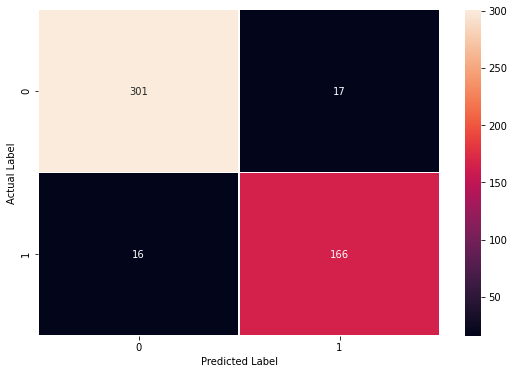

In [16]:
# Make Confusion Matrix
plt.figure(figsize=(9, 6))
y_true = pd.Series(Y_test.numpy().squeeze(), name="Actual Label")
y_pred = pd.Series(Y_hat.squeeze(), name="Predicted Label")
sns.heatmap(pd.crosstab(y_true, y_pred), annot=True, fmt="d", linewidths=0.25)
plt.ylim(len(set(Y_test.numpy())), 0)  # Fix limits, matplotlib bugged (ver. 3.11)


In [0]:
#X = np.expand_dims(X, axis=1)
output = np.concatenate((Y_hat, Y_test.numpy().reshape(-1, 1), data[1600:2100, 6:7].reshape(-1, 1)), axis=1)
df = pd.DataFrame(output)

output_file = "/content/drive/My Drive/Colab Notebooks/NLP Tweet Classification/NLP_Tweet_Classification_Results.csv"
df.to_csv(output_file, header=False, index=False)